In [2]:
#basic imports and ipython setup
import matplotlib.pyplot as plt
import numpy as np

from MCEq.core import MCEqRun
import crflux.models as crf
import mceq_config as config
import crflux.models as pm

from tqdm import tqdm

from scipy.sparse import identity
from scipy.sparse import find

from scipy.linalg import expm

from functools import reduce

from time import time

import pandas as pd
from MCEq.geometry.density_profiles import GeneralizedTarget

import matplotlib as mpl
from cycler import cycler

In [3]:
colors = mpl.cm.viridis(np.linspace(0., 1., 5))

axes_style = { 'grid'      : 'True',
               'labelsize' : '14',
               'labelpad'  : '8.0',
               'prop_cycle': cycler('color', colors) }
grid_style = { 'alpha'     : '0.75',
               'linestyle' : ':' }
font_style = { 'size'      : '14' }

mpl.rc('font', **font_style)
mpl.rc('axes', **axes_style)
mpl.rc('grid', **grid_style)

In [4]:
def surface_flux(cosTH, primary_model = (pm.GlobalSplineFitBeta, None), interaction_model = 'DPMJETIII191', density_model = ('CORSIKA',('SouthPole', 'December')), elev = 3120, sol=True, use_tqdm=False):
    import mceq_config as config
    
    config.debug_level = 0
    
    # Generic settings
    ## config.max_density = 1.
    config.h_obs = elev # elevation in (m) of Dome-C
    
    #config.hybrid_crossover = 0.3
    config.enable_default_tracking = False
    #config.adv_set["allowed_projectiles"] = [13, 111, 130, 211, 310, 321, 411, 421, 431, 2122, 2212, 3122]
    #config.adv_set["exclude_from_mixing"] = [13, 211, 321 ]#,2112, 3122
    #config.adv_set["force_resonance"] = [421, 411, 431, 111,310]
    ## config.adv_set["disabled_particles"] = [111]
    #config.e_min = 1e-3 # This is the lowest stable limit 60 MeV
    #config.e_max = 1e9
    #config.dXmax = 1.
    #config.leading_process = 'auto'
    #config.enable_energy_loss = True
    #config.average_loss_operator = True
    #config.loss_step_for_average = 1e-5
    #config.generic_losses_all_charged = True
    #config.enable_em_ion = True
    #config.enable_cont_rad_loss = False
    ##config.enable_em = True
    #config.excpt_on_missing_particle = True
    #config.muon_helicity_dependence = True
    ##: File name of the MCEq database
    #config.em_db_fname = "mceq_db_EM_Tsai_Max_v131.h5"
    #config.mceq_db_fname = 'mceq_db_lext_dpm191_v131_VM.h5'
    #density_model = ('CORSIKA',('SouthPole', 'December'))
    #density_model = ('CORSIKA', ('USStd', None))
    
    config.max_density = 0.001225
    config.dedx_material = 'air'

    mceq = MCEqRun(
        interaction_model=interaction_model,
        theta_deg = 180*np.arccos(cosTH)/np.pi,
        density_model = density_model,
        #medium=medium,
        primary_model = primary_model,
    )
    
    if sol:
        #mceq.solve()
        
        solve_mceq(mceq, use_tqdm=use_tqdm)
    
    return mceq

In [5]:
def depth_flux(flux, z, h, cosTH, rho=None, interaction_model = 'DPMJETIII191', sol=True, use_tqdm=False):
    #print('Calculating flux through ice at {:.1f} degrees'.format(180*np.arccos(cosTH)/np.pi))
    
    import mceq_config as config
    
    # Generic settings
    ## config.max_density = 1.
    #config.hybrid_crossover = 0.3
    config.enable_default_tracking = False
    #config.adv_set["exclude_from_mixing"] = [13, 211, 321 ]#,2112, 3122
    #config.adv_set["force_resonance"] = [421, 411, 431, 111,310]
    ## config.adv_set["disabled_particles"] = [111]
    #config.e_min = 1e-3 # This is the lowest stable limit 60 MeV
    #config.e_max = 1e9
    #config.e_min = 1
    #config.e_max = 1e9
    config.debug_level = 0 #2
    #config.dXmax = 1.
    #config.leading_process = 'auto'
    #config.enable_energy_loss = True
    #config.average_loss_operator = True
    #config.loss_step_for_average = 1e-5
    #config.generic_losses_all_charged = True
    #config.enable_em_ion = True
    #config.enable_cont_rad_loss = False
    #config.enable_em = True
    #config.excpt_on_missing_particle = True
    #config.muon_helicity_dependence = True
    ##: File name of the MCEq database
    #config.em_db_fname = "mceq_db_EM_Tsai_Max_v131.h5"
    #config.mceq_db_fname = 'mceq_db_lext_dpm191_v131_VM.h5'
    primary_model = (pm.GlobalSplineFitBeta, None)
    
    #medium = 'water'
    #density = 1.
    medium = 'ice'
    if rho is None:
        density = 0.9239
        ## medium = 'iron'
        ## density = 7.864
        target = GeneralizedTarget(len_target=h[-1]*100/cosTH/density) # 1km
        target.add_material(0.,density,medium)
    else:
        target = GeneralizedTarget(len_target=z[-1]*100/cosTH, env_density = rho_ice, env_name = 'ice')
        target.mat_list = [[z[i]*100/cosTH, z[i+1]*100/cosTH, rho[i], 'ice'] for i in range(len(z)-1)]
        target._update_variables()
    ## config.A_target = 18/3.
    config.max_density = 0.9239
    config.dedx_material = 'ice'

    mceq = MCEqRun(
        interaction_model = interaction_model,
        theta_deg = 0,
        density_model = target,
        medium=medium,
        primary_model = primary_model,
    )

    mceq._phi0 = flux
    
    if sol:
        #mceq.solve()
        #mceq.solve(int_grid=h/cosTH*100)
        
        solve_mceq(mceq, int_grid=h/cosTH*100, use_tqdm=use_tqdm)
    
    return mceq

In [6]:
def solve_mceq(mceq, int_grid=None, grid_var='X', use_tqdm=False):
    mceq._calculate_integration_path(int_grid=int_grid, grid_var=grid_var)

    nsteps, dX, rho_inv, grid_idcs = mceq.integration_path
    int_m = mceq.int_m
    dec_m = mceq.dec_m

    dXaccum = 0.
    grid_sol = np.zeros((len(grid_idcs), *np.shape(mceq._phi0)))
    grid_step = 0

    phc = np.copy(mceq._phi0)
    
    for step in (tqdm(range(nsteps)) if use_tqdm else range(nsteps)):
        phc += (int_m.dot(phc) + dec_m.dot(rho_inv[step] * phc)) * dX[step]
        phc[phc<1e-250] = 0.

        if (grid_idcs and grid_step < len(grid_idcs)
                and grid_idcs[grid_step] == step):
            grid_sol[grid_step] = np.copy(phc)
            grid_step += 1

    mceq._solution, mceq.grid_sol = phc, grid_sol
    
    return

In [7]:
def flux_matrix_one_ang(i_range, z, h, cosTH, rho=None, interaction_model = 'DPMJETIII191', elev = 3120):
    print('Calculating muon flux response at {:.1f} degrees'.format(180*np.arccos(cosTH)/np.pi))
    
    mceq = surface_flux(cosTH, interaction_model=interaction_model, elev=elev, sol=False)
    
    phi0 = np.zeros((len(mceq._phi0), len(i_range)))
    phi0[i_range,np.arange(len(i_range))] = 1.
    #phi0[i_range] = np.identity(len(i_range))
    
    mceq._phi0 = phi0
    solve_mceq(mceq, use_tqdm=True)
    
    print('Propagating through ice...')
    
    mceq_fin = depth_flux(mceq._solution, z, h, cosTH, rho, interaction_model = interaction_model, use_tqdm=True)
    
    print('Retrieving Muon Flux...')
    
    phi_sum = mceq_fin.grid_sol[:,4*121:5*121] + mceq_fin.grid_sol[:,5*121:6*121] + mceq_fin.grid_sol[:,6*121:7*121] + mceq_fin.grid_sol[:,7*121:8*121] + mceq_fin.grid_sol[:,8*121:9*121] + mceq_fin.grid_sol[:,9*121:10*121]
    phi_int = phi_sum * mceq_fin._energy_grid.w.reshape((1,-1,1))

    return mceq_fin._energy_grid.c, phi_int
    # axis0 : depth
    # axis1 : muon energy
    # axis2 : CR particle & energy

In [241]:
def flux_matrix_all(i_range, z, h, cosTH, dcosTH, rho=None, interaction_model = 'DPMJETIII191', elev = 3120):
    
    
    E_grid, phi_mu_tot = flux_matrix_one_ang(i_range, z, h, cosTH[0], rho, interaction_model = interaction_model, elev = elev)
    phi_mu_tot *= dcosTH
    for i in range(1,len(cosTH)):
        phi_mu_tot += flux_matrix_one_ang(i_range, z, h, cosTH[i], rho, interaction_model = interaction_model, elev = elev)[1] * dcosTH

    return 2*np.pi*phi_mu_tot

In [9]:
def SDC(E0, cosTH):
    # Smith & Duller / Chatzidakis
    
    A = 0.002382 # fitting parameter
    r = 0.76 # Ratio of muon energy to pion energy
    a = 2.500e-3 # Muon rate of energy loss in air (GeV / (g/cm^2))
    y0 = 1000 # Atmosphere depth at sea level (g/cm^2)
    gamma = 8/3 # fitting parameter
    b_mu = 0.800 # Correction factor related to atmospheric temperature
    m_mu = 105.659e-3 # Rest mass of muon (GeV/c^2)
    tau_mu0 = 2.2e-6 # Mean lifetime of muon at rest (s)
    rho0 = 0.00123 # Density of atmosphere at sea level (g/cm^3)
    c = 3e10 # speed of light (cm/s)
    lambda_pi = 120 # Absorption mean free path of pions (g/cm^2)
    b = 0.771 # coefficient to modify the isothermal atmosphere approximation
    tau0 = 2.61e-8 # Mean lifetime of pion at rest (s)
    m_pi = 139.580e-3 # Rest mass of pion (GeV/c^2)
    j_pi = 148.16 # m_pi * y0 * c / (tau0 * rho0) GeV
    
    # energy of pion that produced muon
    E_pi = (E0 + a*y0*(1/cosTH - 0.100))/r
    
    B_mu = b_mu * m_mu * y0 / (c * tau_mu0 * rho0)
    
    # Probability for muons to reach sea level
    P_mu = (0.100 * cosTH * (1-a*(y0/cosTH - 100)/(r * E_pi)))**(B_mu / ((r*E_pi + 100*a)*cosTH))
    
    Phi_S = A * E_pi**(-gamma) * P_mu * lambda_pi * b * j_pi/(E_pi* cosTH + b * j_pi)
    
    return Phi_S

In [10]:
age_scale_file = 'DomeC_age_scale_Apr2023.csv'
ice_eq_depth_file = 'Real_vs_ice_eq_depth.csv'

age_scale = pd.read_csv(age_scale_file)
ages = np.array(age_scale['ages']) # years
depths_real = np.array(age_scale['depths_real']) # meters

ice_eq_depth = pd.read_csv(ice_eq_depth_file)
real_z = ice_eq_depth['z'] # meters
ice_eq_z = ice_eq_depth['ice_eq_z'] # meters (ice-eq)

In [11]:
def z_to_t(z): # convert real depth to age
    return np.interp(z, depths_real, ages)

def t_to_z(t): # convert age to real depth
    return np.interp(t, ages, depths_real)

def z_to_h(z): # convert real depth to mass depth
    return np.interp(z, real_z, ice_eq_z)*rho_ice

def h_to_z(h): # convert mass depth to real depth
    return np.interp(h/rho_ice, ice_eq_z, real_z)

def h_to_t(h): # convert mass depth to age
    return z_to_t(h_to_z(h/rho_ice))

def t_to_h(t): # convert age to mass depth
    return z_to_h(t_to_z(t))*rho_ice

Text(0.5, 1.0, 'Ice Depth by Relative Age')

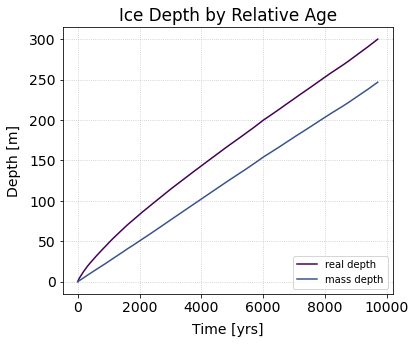

In [109]:
z_min = 0
z_start = 96.5 # starting real depth of model (m)
z_deep = 300 # end depth (m)
rho_ice = 0.9239 # density of solid ice at Dome C (g/cm^3)

i_min = np.argmin(abs(depths_real-z_min))
i_start = np.argmin(abs(depths_real-z_start))
i_end = np.argmin(abs(depths_real-z_deep))
z = depths_real[i_min:i_end+1]
dz = depths_real[i_min+1:i_end+2] - z

i_int = np.arange(i_start, i_end+1)

h = z_to_h(z)
dh = z_to_h(depths_real[i_min+1:i_end+2]) - h
t = np.arange(len(z))
dt = 1

fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(t, z, label='real depth')
ax.plot(t, h, label='mass depth')
ax.set(xlabel='Time [yrs]',
       ylabel='Depth [m]')
ax.legend(loc='lower right', fontsize=10)
plt.title('Ice Depth by Relative Age')

Text(0.5, 1.0, 'Ice Density Profile')

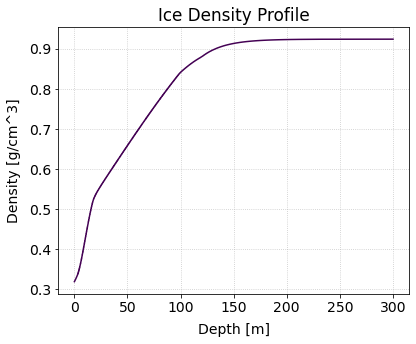

In [13]:
rho = dh/dz # calculate density from change in mass depth / real depth

fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(z, rho)
ax.set(xlabel='Depth [m]',
       ylabel='Density [g/cm^3]')
#ax.legend(loc='lower right', fontsize=10)
plt.title('Ice Density Profile')

In [14]:
dcosTH = 0.1
cosTH = np.arange(1,0,-dcosTH)

#dz = 1
#z = np.arange(0,300+dz, dz)

In [15]:
# Is this step calculating the average momentum for a given depth and finding the atmospheric attenuation length
# for that momentum?

# If Attenuation varies by momentum, shouldn't the energy spectrum change as a result?


pressure = 65800 # surface pressure in Pa, should be 65800 for Dome C

# figure the difference in atmospheric depth from sea level in g/cm2
H = (1013.25 - pressure/100)*1.019716 # the 1.019716 number is basically just 1/g accounting for needed unit conversions

# define range/momentum relation
# table for muons in standard rock in Groom and others 2001

# g/cm^2
h_range = np.array([8.516e-1, 1.542e0, 2.866e0, 5.698e0, 9.145e0, 2.676e1, 3.696e1, 5.879e1, 9.332e1, 1.524e2,
                    2.115e2, 4.418e2, 5.534e2, 7.712e2, 1.088e3, 1.599e3, 2.095e3, 3.998e3, 4.920e3, 6.724e3,
                    9.360e3, 1.362e4, 1.776e4, 3.343e4, 4.084e4, 5.495e4, 7.459e4, 1.040e5, 1.302e5, 2.129e5])

# MeV/c
momentum = np.array([4.704e1, 5.616e1, 6.802e1, 8.509e1, 1.003e2, 1.527e2, 1.764e2, 2.218e2, 2.868e2, 3.917e2,
                     4.945e2, 8.995e2, 1.101e3, 1.502e3, 2.103e3, 3.104e3, 4.104e3, 8.105e3, 1.011e4, 1.411e4,
                     2.011e4, 3.011e4, 4.011e4, 8.011e4, 1.001e5, 1.401e5, 2.001e5, 3.001e5, 4.001e5, 8.001e5])

def att_L(h):
    # effective atmospheric attenuation length for muons at mass depth h
    
    P_MeVc = np.exp(np.interp(np.log(h*100), np.log(h_range), np.log(momentum)))
    
    return 263 + 150 * P_MeVc/1000

In [16]:
def phi_vert_slhl(h):
    #parameters
    p = [258.5,  #p0
        -5.5e-4, #p1
        210,     #p2
        10,      #p3
        1.66,    #p4
        75]      #p5
    
    a = np.exp(p[1] * h)
    b = h + p[2]
    c = (h+p[3])**p[4] + p[5]
    
    Phi_v = p[0] * a / b / c  # cm^-2 s^-1 sr^-1
    
    return Phi_v

In [17]:
def R_vert_slhl(h):
    #parameters
    p = [258.5,  #p0
        -5.5e-4, #p1
        210,     #p2
        10,      #p3
        1.66,    #p4
        75]      #p5
    
    a = np.exp(p[1] * h)
    b = h + p[2]
    c = (h+p[3])**p[4] + p[5]
    
    dadh = p[1] * a
    dbdh = 1.
    dcdh = p[4] * (h+p[3])**(p[4]-1)
    
    R_v = -p[0] * (b*c*dadh - a*c*dbdh - a*b*dcdh)/ b**2 / c**2  # hg^-1 s^-1 sr^-1
    
    return R_v

In [18]:
def phi_vert_site(h, dh, H=H, h_end=2e3):
    
    Phi_v= phi_vert_slhl(h)
    
    R_v = R_vert_slhl(h)
    
    R_site = R_v * np.exp(H/att_L(h))
    
    Phi_end = phi_vert_slhl(h_end)
    
    dh_ext = 1
    h_ext = np.arange(h[-1]+dh_ext, h_end+dh_ext, dh_ext)
    
    h_int = np.append(h, h_ext)
    dh_int = np.append(dh, dh_ext + 0*h_ext)
    
    R_int = R_vert_slhl(h_int) * np.exp(H/att_L(h_int))
    
    Phi_site = np.flip(np.cumsum(np.flip(R_int * dh_int))) + (1-np.exp(H/att_L(h_end)))*Phi_end
    
    Phi_site = Phi_site[:len(h)]
    
    #approximation where the exponential is almost constant in h
    #Phi_site = Phi_v * np.exp(H/att_L(h)) + (1-np.exp(H/att_L(h_end)))*Phi_end
    
    return Phi_site, R_site

In [19]:
def cos_pow(h, H=H):
    #parameters
    p = [3.21,     #p0
         0.297,    #p1
         42,       #p2
         1.21e-3]  #p3
    
    #H = (1013.25 - pressure/100) * 1.019716
    #h_mod = h + H (atmospheric depth diff. from sea level)
    
    # shouldn't H be subtracted here?
    
    n = p[0] - p[1]*np.log(h + H/100 + p[2]) + p[3] * (h + H/100)
    
    dndh = -p[1]/(h + H/100 + p[2]) + p[3]
    
    return n, dndh

In [20]:
def f_mu_neg(h = None):
    K_mu = 1.268 # +/- 0.008 + 0.002 * E[GeV]
    
    return 1/(K_mu+1)

In [21]:
def phi_all(h, dh, H=H, cos_pow_func=cos_pow, f_func=f_mu_neg):
    
    n, dndh = cos_pow_func(h, H)
    
    Phi_v, R_v = phi_vert_site(h, dh, H)
    
    Phi = 2*np.pi/(n+1) * Phi_v
    
    R = f_func(h) * (2*np.pi * R_v + Phi*dndh) / (n+1)
    
    return Phi, R # cm^-2 s^-1

In [22]:
def Heisinger(h):
    #parameters
    a = 7.6
    b = 321.7
    c = 8.059e-4
    d = 50.7
    e = 5.05e-5
    
    f = 0.846
    g = 0.015
    i = 0.003139
    
    # Heisinger's fit for average Energy
    E_pred = a + b * (1-np.exp(-c*h)) + d*(1-np.exp(-e*h))

    # Heisinger's Beta correction term
    Beta_pred = f - g*np.log(h+1)+i*np.log(h+1)**2
    
    return E_pred, Beta_pred

In [23]:
def get_primary(primary_model = (pm.GlobalSplineFitBeta, None)):
    mceq = surface_flux(0, primary_model=primary_model, sol=False)
    return mceq, np.concatenate((mceq._phi0[31*121:32*121], mceq._phi0[29*121:30*121]))

In [24]:
#interaction_model = 'DPMJETIII191'
interaction_model = "SIBYLL-2.3c"
#interaction_model = "EPOS-LHC"

In [25]:
phi_mu_tot = np.load('flux_mat_{}.npy'.format(interaction_model))

In [242]:
#phi_mu_tot = flux_matrix_all(np.concatenate((np.arange(121)+31*121, np.arange(121)+29*121)), z, h, cosTH, dcosTH, rho=rho, interaction_model = interaction_model, elev = 3120)

In [27]:
#np.save('flux_mat_{}.npy'.format(interaction_model), phi_mu_tot)

In [28]:
Phi, R = phi_all(h, dh+h*0)
Phi0, R0 = phi_all(h, dh+h*0, H=0)

C:\Users\walte\AppData\Local\Temp/ipykernel_12964/881969149.py:28: RuntimeWarning: divide by zero encountered in log
  P_MeVc = np.exp(np.interp(np.log(h*100), np.log(h_range), np.log(momentum)))


In [29]:
p_models = [(pm.GlobalSplineFitBeta, None), (pm.HillasGaisser2012, "H3a"), (pm.HillasGaisser2012, "H4a"), (pm.PolyGonato, False),
           (pm.GaisserStanevTilav, "3-gen"), (pm.GaisserStanevTilav, "4-gen"), (pm.CombinedGHandHG, "H3a"),
           (pm.ZatsepinSokolskaya, "pamela"), (pm.ZatsepinSokolskaya, "default"), (pm.GaisserHonda, None),
           (pm.Thunman, None), (pm.SimplePowerlaw27, None)]
model_names = ['GlobalSplineFitBeta', 'HillasGaisser2012 H3a', 'HillasGaisser2012 H4a', 'PolyGonato',
              'GaisserStanevTilav 3-gen', 'GaisserStanevTilav 4-gen', 'CombinedGHandHG H3a',
              'ZatsepinSokolskaya pamela', 'ZatsepinSokolskaya default', 'GaisserHonda',
              'Thunman', 'SimplePowerlaw27']

In [30]:
mceq = surface_flux(1, sol=False)
E_grid = mceq._energy_grid.c

In [31]:
Primaries = [get_primary(p)[1] for p in p_models]

In [32]:
MU_spect = [phi_mu_tot @ phi0 for phi0 in Primaries]
MU_tot = [np.sum(mu_spect, axis=1) for mu_spect in MU_spect]
E_MU_avg = [np.sum(MU_spect[i]*E_grid, axis=1)/MU_tot[i] for i in range(len(MU_spect))]
E_MU_alph = [np.sum(MU_spect[i]*E_grid**0.75, axis=1) for i in range(len(MU_spect))]
MU_R = [-np.diff(mu_tot, append=0)/dh for mu_tot in MU_tot]

In [33]:
E_flux = np.expand_dims(mceq._energy_grid.c,axis=1)
SDC_flux = SDC(E_flux, cosTH).T

# Negative muon ratio (Cited by Heisinger)
K_mu = 1.268 # +/- 0.008 + 0.002 * E[GeV]

phi_SDC = np.array([0*mceq._solution for cth in cosTH])
phi_SDC[:, mceq.pman.pname2pref['mu+'].lidx : mceq.pman.pname2pref['mu+'].uidx] = SDC_flux / (K_mu+1) # positive muons
phi_SDC[:, mceq.pman.pname2pref['mu-'].lidx : mceq.pman.pname2pref['mu-'].uidx] = SDC_flux / (1 + 1/K_mu) # negative muons

In [34]:
mceq_depth_SDC = [depth_flux(phi_SDC[i], z, h, cosTH[i], rho, interaction_model=interaction_model, use_tqdm=True) for i in range(len(cosTH))]

100%|███████████████████████████████████████████████████████████████████████████| 29139/29139 [01:43<00:00, 282.81it/s]


In [35]:
longitudinal_spectrum_SDC = np.array([[mceq_depth_SDC[i].get_solution('mu-', grid_idx=idx, integrate=True)+mceq_depth_SDC[i].get_solution('mu+', grid_idx=idx, integrate=True) for idx in range(len(h))] for i in range(len(cosTH))])
Spec_tot_SDC = 2*np.pi*np.sum(longitudinal_spectrum_SDC*dcosTH, axis=(0,2)) # number of particles per cm^2 per s?
E_avg_SDC = 2*np.pi*np.sum(longitudinal_spectrum_SDC * dcosTH * mceq_depth_SDC[0]._energy_grid.c, axis=(0,2))/Spec_tot_SDC
E_alph_SDC = 2*np.pi*np.sum(longitudinal_spectrum_SDC * dcosTH * mceq_depth_SDC[0]._energy_grid.c**0.75, axis=(0,2))
R_SDC = -np.diff(Spec_tot_SDC, append=0)/dh

In [36]:
np.sum(longitudinal_spectrum_SDC[0,0])/phi_vert_slhl(0)

0.7934888394638677

Text(0.5, 1.0, 'Total Muon Flux over Depth')

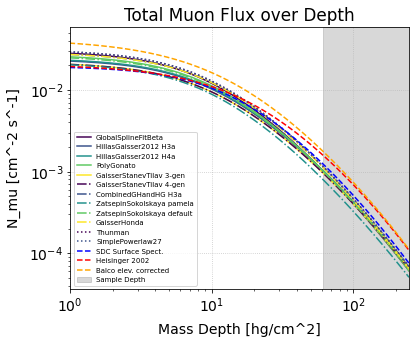

In [37]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.axvspan(h[z>96.5][0], h[-1], color='grey', alpha=0.3, label='Sample Depth')
for i,mu_tot in enumerate(MU_tot):
    if i//5 == 0:
        ls = '-'
    elif i//5 == 1:
        ls = '-.'
    else:
        ls = ':'
    ax.plot(h, mu_tot, ls=ls, label=model_names[i])
ax.plot(h, Spec_tot_SDC, ls='--', c='blue', label='SDC Surface Spect.')
ax.plot(h, Phi0, ls='--', c='red', label='Heisinger 2002')
ax.plot(h, Phi, ls='--', c='orange', label='Balco elev. corrected')
ax.set(xlim = (1, h[-1]),
       xscale = 'log',
       xlabel='Mass Depth [hg/cm^2]',
       yscale = 'log',
       ylabel='N_mu [cm^-2 s^-1]')
ax.legend(loc='lower left', fontsize=7)
plt.title('Total Muon Flux over Depth')

Text(0.5, 1.0, 'Total Muon Flux over Depth')

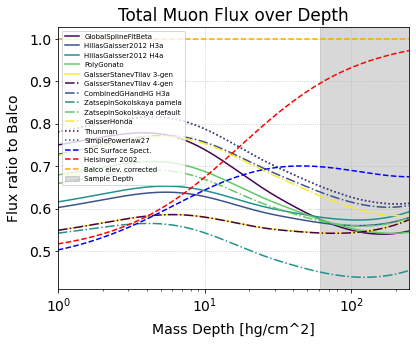

In [38]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.axvspan(h[z>96.5][0], h[-1], color='grey', alpha=0.3, label='Sample Depth')
for i,mu_tot in enumerate(MU_tot):
    if i//5 == 0:
        ls = '-'
    elif i//5 == 1:
        ls = '-.'
    else:
        ls = ':'
    ax.plot(h, mu_tot/Phi, ls=ls, label=model_names[i])
ax.plot(h, Spec_tot_SDC/Phi, ls='--', c='blue', label='SDC Surface Spect.')
ax.plot(h, Phi0/Phi, ls='--', c='red', label='Heisinger 2002')
ax.plot(h, Phi/Phi, ls='--', c='orange', label='Balco elev. corrected')
ax.set(xlim = (1, h[-1]),
       xscale = 'log',
       xlabel='Mass Depth [hg/cm^2]',
       #yscale = 'log',
       ylabel='Flux ratio to Balco')
ax.legend(loc='best', fontsize=7)
plt.title('Total Muon Flux over Depth')

Text(0.5, 1.0, 'Average Muon Energy over Depth')

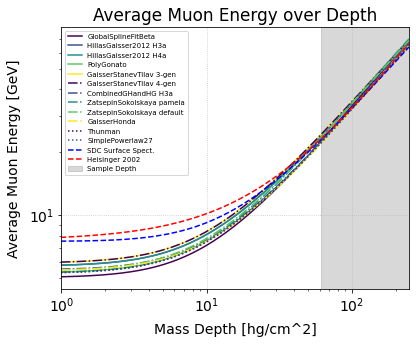

In [39]:
E_pred, Beta_pred = Heisinger(h)

fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.axvspan(h[z>96.5][0], h[-1], color='grey', alpha=0.3, label='Sample Depth')
for i,E_mu_avg in enumerate(E_MU_avg):
    if i//5 == 0:
        ls = '-'
    elif i//5 == 1:
        ls = '-.'
    else:
        ls = ':'
    ax.plot(h, E_mu_avg, ls=ls, label=model_names[i])
ax.plot(h, E_avg_SDC, ls='--', c='blue', label='SDC Surface Spect.')
ax.plot(h, E_pred, ls='--', c='red', label='Heisinger 2002')
ax.set(xlim = (1, h[-1]),
       xscale = 'log',
       xlabel='Mass Depth [hg/cm^2]',
       #ylim = (1,1000),
       yscale = 'log',
       ylabel='Average Muon Energy [GeV]')
ax.legend(loc='upper left', fontsize=7)
plt.title('Average Muon Energy over Depth')

Text(0.5, 1.0, 'Average Muon Energy over Depth')

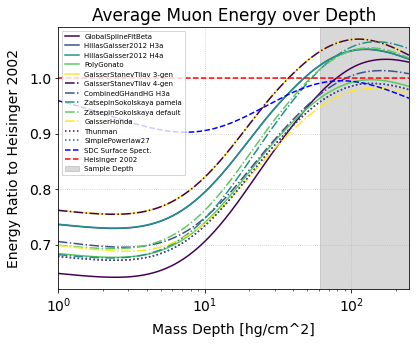

In [40]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.axvspan(h[z>96.5][0], h[-1], color='grey', alpha=0.3, label='Sample Depth')

for i,E_mu_avg in enumerate(E_MU_avg):
    if i//5 == 0:
        ls = '-'
    elif i//5 == 1:
        ls = '-.'
    else:
        ls = ':'
    ax.plot(h, E_mu_avg/E_pred, ls=ls, label=model_names[i])
ax.plot(h, E_avg_SDC/E_pred, ls='--', c='blue', label='SDC Surface Spect.')
ax.plot(h, E_pred/E_pred, ls='--', c='red', label='Heisinger 2002')
ax.set(xlim = (1, h[-1]),
       xscale = 'log',
       xlabel='Mass Depth [hg/cm^2]',
       #ylim = (1,1000),
       #yscale = 'log',
       ylabel='Energy Ratio to Heisinger 2002')
ax.legend(loc='upper left', fontsize=7)
plt.title('Average Muon Energy over Depth')

In [41]:
# Negative Muon Capture parameters (Heisinger)
f_C = 1 # value should be absolute
f_D = 0.1828 #error unknown
f_star, df_star = 0.137, 0.011 
#f_star, df_star = 4.4e-3/f_C/f_D, 2.6e-3/f_C/f_D

# Fast Muon Interaction parameters (Heisinger)
sigma_190, dsigma_190 = 4.5e-28, 2.5e-28 #cm^2
alpha = 0.75
#sigma_190, dsigma_190 = 2.4e-30*190**alpha, 1.8e-30*190**alpha #Dyonisius 2023
#sigma_0 = sigma_190 / 190**alpha #8.8e-30 +/- 4.9e-30 cm^2 = 8.8 +/- 4.9 mu b
N = 6.022e23 / 0.1802 # hg^-1

# Decay parameter
lambd=1.21e-4 #yr^-1

# Production rate adjustment from Taylor Glacier data
f_neg = 0.066
f_fast = 0.072

In [42]:
def P_rates(R, E_mu_alph, alpha=alpha):
    
    sigma_0 = sigma_190 / 190**alpha #8.8e-30 +/- 4.9e-30 cm^2 = 8.8 +/- 4.9 mu b
    
    P_neg = f_mu_neg() * R * f_C * f_D * f_star
    
    P_fast = sigma_0 * E_mu_alph * N
    
    return np.array([P_neg, P_fast]) /100 * 60 * 60 * 24 * 365.25 # g^-1, a^-1

In [43]:
P_neg_pred, P_fast_pred = P_rates(R/f_mu_neg(), Phi*E_pred**alpha*Beta_pred)

In [44]:
P_ALL = np.array([P_rates(MU_R[i], E_MU_alph[i]) for i in range(len(MU_R))])
P_NEG = P_ALL[:,0]
P_FAST = P_ALL[:,1]

In [45]:
P_neg_SDC, P_fast_SDC = P_rates(R_SDC, E_alph_SDC)

Text(0.5, 1.0, 'In Situ 14CO Production Rates over Depth')

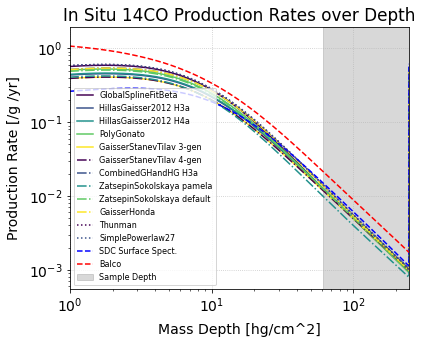

In [46]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.axvspan(h[z>96.5][0], h[-1], color='grey', alpha=0.3, label='Sample Depth')
#ax.fill_between(h, P_neg*(1 + df_star/f_star), P_neg*(1 - df_star/f_star), alpha=0.3)
#ax.fill_between(h, P_fast_F*(1+dsigma_190/sigma_190), P_fast_F*(1-dsigma_190/sigma_190), alpha=0.3)
#ax.fill_between(h, P_fast_P*(1+dsigma_190/sigma_190), P_fast_P*(1-dsigma_190/sigma_190), alpha=0.3)

for i in range(len(MU_R)):
    if i//5 == 0:
        ls = '-'
    elif i//5 == 1:
        ls = '-.'
    else:
        ls = ':'
    ax.plot(h, P_NEG[i]*f_neg+P_FAST[i]*f_fast, ls=ls, label=model_names[i])

ax.plot(h, P_neg_SDC*f_neg+P_fast_SDC*f_fast, c='b', ls='--', label='SDC Surface Spect.')
ax.plot(h, P_neg_pred*f_neg+P_fast_pred*f_fast, c='r', ls='--', label='Balco')
ax.set(xlabel='Mass Depth [hg/cm^2]',
       xlim = (1, h[-1]),
       xscale = 'log',
       yscale = 'log',
       ylabel='Production Rate [/g /yr]')
ax.legend(loc='best', fontsize=8)
plt.title('In Situ 14CO Production Rates over Depth')

Text(0.5, 1.0, 'P_fast over Depth')

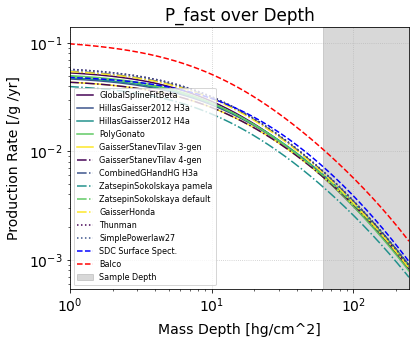

In [47]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.axvspan(h[z>96.5][0], h[-1], color='grey', alpha=0.3, label='Sample Depth')

for i in range(len(MU_R)):
    if i//5 == 0:
        ls = '-'
    elif i//5 == 1:
        ls = '-.'
    else:
        ls = ':'
    ax.plot(h, P_FAST[i]*f_fast, ls=ls, label=model_names[i])

ax.plot(h, P_fast_SDC*f_fast, c='b', ls='--', label='SDC Surface Spect.')
ax.plot(h, P_fast_pred*f_fast, c='r', ls='--', label='Balco')
ax.set(xlabel='Mass Depth [hg/cm^2]',
       xlim = (1, h[-1]),
       xscale = 'log',
       yscale = 'log',
       ylabel='Production Rate [/g /yr]')
ax.legend(loc='best', fontsize=8)
plt.title('P_fast over Depth')

Text(0.5, 1.0, 'P_neg over Depth')

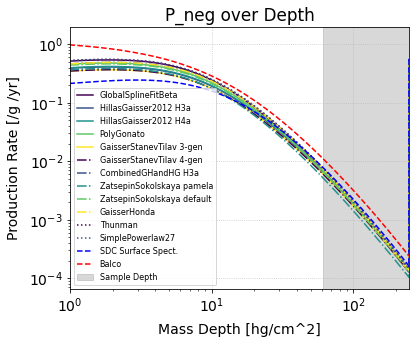

In [48]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.axvspan(h[z>96.5][0], h[-1], color='grey', alpha=0.3, label='Sample Depth')
#ax.fill_between(h, P_neg*(1 + df_star/f_star), P_neg*(1 - df_star/f_star), alpha=0.3)
#ax.fill_between(h, P_fast_F*(1+dsigma_190/sigma_190), P_fast_F*(1-dsigma_190/sigma_190), alpha=0.3)
#ax.fill_between(h, P_fast_P*(1+dsigma_190/sigma_190), P_fast_P*(1-dsigma_190/sigma_190), alpha=0.3)

for i in range(len(MU_R)):
    if i//5 == 0:
        ls = '-'
    elif i//5 == 1:
        ls = '-.'
    else:
        ls = ':'
    ax.plot(h, P_NEG[i]*f_neg, ls=ls, label=model_names[i])

ax.plot(h, P_neg_SDC*f_neg, c='b', ls='--', label='SDC Surface Spect.')
ax.plot(h, P_neg_pred*f_neg, c='r', ls='--', label='Balco')
ax.set(xlabel='Mass Depth [hg/cm^2]',
       xlim = (1, h[-1]),
       xscale = 'log',
       yscale = 'log',
       ylabel='Production Rate [/g /yr]')
ax.legend(loc='best', fontsize=8)
plt.title('P_neg over Depth')

In [50]:
def roll_zeros(x, shift): #roll array and zero out values which go out of bounds; shift>0
    y = np.roll(x, shift)
    y[:shift] = 0
    return y

In [116]:
def M_conv(P):
    # axis0 = production mode
    # axis1 = time (present -> past)
    # axis2 = depth
    P_out = np.array([[roll_zeros(p, i) for i in range(len(p))] for p in P])
    
    # axis0 = production mode
    # axis1 = depth
    # axis2 = time
    P_out = np.swapaxes(P_out, 1, 2)
    
    # axis2 = time (past -> present)
    P_out = np.flip(P_out, axis=2)
    
    return P_out

In [117]:
def decay_matrix(t, lambd=lambd):
    return np.expand_dims(np.diag((1-lambd)**(t[-1]-t)), axis=0)

In [118]:
def const_func(t, f_neg = f_neg, f_fast=f_fast):
    
    return 0*t + f_neg, 0*t + f_fast

In [119]:
def lin_func(t, slope=0.1, f_neg = f_neg, f_fast=f_fast):
    t_scale = (t - t[-1])/(t[-1] - t[0])
    
    return f_neg*(1+slope*t_scale), f_fast*(1+slope*t_scale)

In [120]:
def step_func(t, amp=0.1, f_neg = f_neg, f_fast=f_fast):
    t_scale = (t - t[0])/(t[-1] - t[0])
    
    return f_neg*(1+amp*(t_scale>0.5))/(1+amp), f_fast*(1+amp*(t_scale>0.5))/(1+amp)

In [121]:
def f_all(t, f_func = const_func, args=()):
    
    f_neg, f_fast = f_func(t, *args)
    
    return np.expand_dims([f_neg, f_fast], axis=2)

In [122]:
P_pred = M_conv(np.array([P_neg_pred[i_int], P_fast_pred[i_int]]))

In [123]:
P_MAT = [M_conv(P_all[:,i_int]) for P_all in P_ALL]

In [124]:
P_SDC = M_conv(np.array([P_neg_SDC[i_int], P_fast_SDC[i_int]]))

In [125]:
L = decay_matrix(t[i_int])

In [126]:
f = f_all(t[i_int])

In [127]:
CO_pred = (P_pred @ (L @ f))[:,:,0]

In [128]:
CO_ALL = [(P @ (L @ f))[:,:,0] for P in P_MAT]

In [129]:
CO_SDC = (P_SDC @ (L @ f))[:,:,0]

In [130]:
slope = -0.05
f_lin = f_all(t[i_int], lin_func, args=(slope,))

In [131]:
CO_lin = (P_pred @ (L @ f_lin))[:,:,0]

In [132]:
step_amp = -0.05
f_step = f_all(t[i_int], step_func, args=(step_amp,))

In [133]:
CO_step = (P_pred @ (L @ f_step))[:,:,0]

Text(0.5, 1.0, 'In Situ 14CO Concentration over Depth (MCEq SIBYLL-2.3c)')

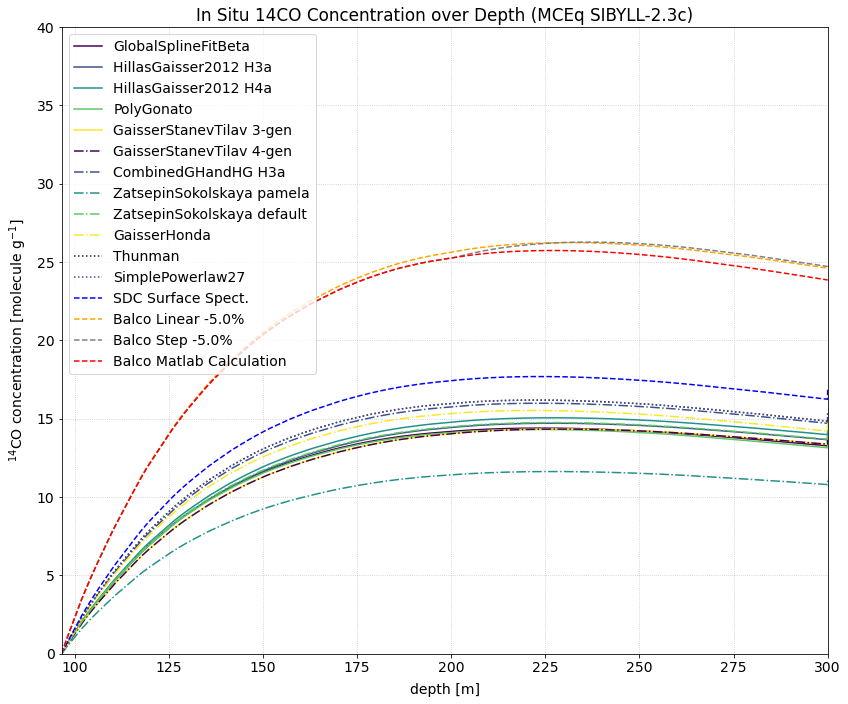

In [193]:
fig, ax = plt.subplots(1,1, figsize=(12,10), tight_layout=True)
#ax.fill_between(z, COH[0]*(1+df_star/f_star), COH[0]*(1-df_star/f_star), alpha=0.3)
#ax.fill_between(z, COH[1]*(1+dsigma_190/sigma_190), COH[1]*(1-dsigma_190/sigma_190), alpha=0.3)

#COH_err = np.sqrt((COH[1]*(dsigma_190/sigma_190))**2 + (COH[0]*(df_star/f_star))**2)
#ax.fill_between(z, np.sum(COH, axis=0)+COH_err, np.sum(COH, axis=0)-COH_err, alpha=0.3)

for i,CO in enumerate(CO_ALL):
    if i//5 == 0:
        ls = '-'
    elif i//5 == 1:
        ls = '-.'
    else:
        ls = ':'
    #ax.plot(z[i_int], np.sum(CO, axis=0), ls=ls, label=model_names[i])
    ax.plot(z[i_int], CO_neg[i] * f_neg + CO_fast[i] * f_fast, ls=ls, label=model_names[i])

ax.plot(z[i_int], np.sum(CO_SDC, axis=0), c='b', ls='--', label='SDC Surface Spect.')
ax.plot(z[i_int], np.sum(CO_lin, axis=0), c='orange', ls='--', label='Balco Linear {:.1f}%'.format(slope*100))
ax.plot(z[i_int], np.sum(CO_step, axis=0), c='grey', ls='--', label='Balco Step {:.1f}%'.format(step_amp*100))
ax.plot(z[i_int], np.sum(CO_pred, axis=0), c='r', ls='--', label='Balco Matlab Calculation')

ax.set(xlim=(z[i_int][0],z[i_int][-1]),
       xlabel='depth [m]',
       ylim=(0,40),
       ylabel=r'$^{14}$CO concentration [molecule g$^{-1}$]')
ax.legend(loc='upper left', fontsize=14)
plt.title('In Situ 14CO Concentration over Depth (MCEq {})'.format(interaction_model))

Text(0.5, 1.0, 'In Situ 14CO Concentration over Depth (MCEq SIBYLL-2.3c)')

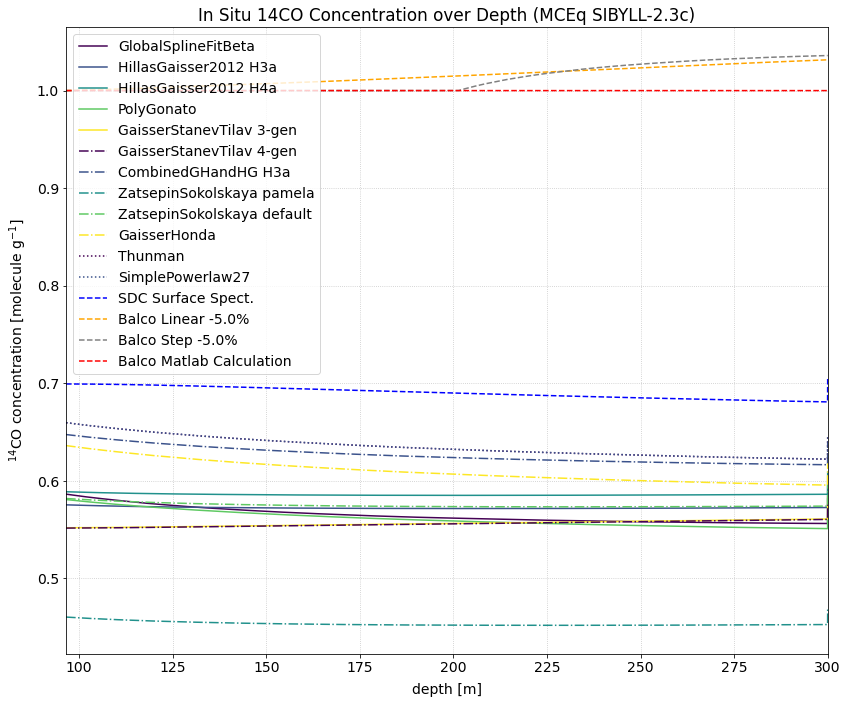

In [135]:
fig, ax = plt.subplots(1,1, figsize=(12,10), tight_layout=True)
#ax.fill_between(z, COH[0]*(1+df_star/f_star), COH[0]*(1-df_star/f_star), alpha=0.3)
#ax.fill_between(z, COH[1]*(1+dsigma_190/sigma_190), COH[1]*(1-dsigma_190/sigma_190), alpha=0.3)

#COH_err = np.sqrt((COH[1]*(dsigma_190/sigma_190))**2 + (COH[0]*(df_star/f_star))**2)
#ax.fill_between(z, np.sum(COH, axis=0)+COH_err, np.sum(COH, axis=0)-COH_err, alpha=0.3)

for i,CO in enumerate(CO_ALL):
    if i//5 == 0:
        ls = '-'
    elif i//5 == 1:
        ls = '-.'
    else:
        ls = ':'
    ax.plot(z[i_int], np.sum(CO, axis=0)/np.sum(CO_pred, axis=0), ls=ls, label=model_names[i])

ax.plot(z[i_int], np.sum(CO_SDC, axis=0)/np.sum(CO_pred, axis=0), c='b', ls='--', label='SDC Surface Spect.')
ax.plot(z[i_int], np.sum(CO_lin, axis=0)/np.sum(CO_pred, axis=0), c='orange', ls='--', label='Balco Linear {:.1f}%'.format(slope*100))
ax.plot(z[i_int], np.sum(CO_step, axis=0)/np.sum(CO_pred, axis=0), c='grey', ls='--', label='Balco Step {:.1f}%'.format(step_amp*100))
ax.plot(z[i_int], np.sum(CO_pred, axis=0)/np.sum(CO_pred, axis=0), c='r', ls='--', label='Balco Matlab Calculation')

ax.set(xlim=(z[i_int][0],z[i_int][-1]),
       xlabel='depth [m]',
       #ylim=(0,40),
       ylabel=r'$^{14}$CO concentration [molecule g$^{-1}$]')
ax.legend(loc='best', fontsize=14)
plt.title('In Situ 14CO Concentration over Depth (MCEq {})'.format(interaction_model))

Text(0.5, 1.0, 'NORMALIZED In Situ 14CO Concentration over Depth (MCEq SIBYLL-2.3c)')

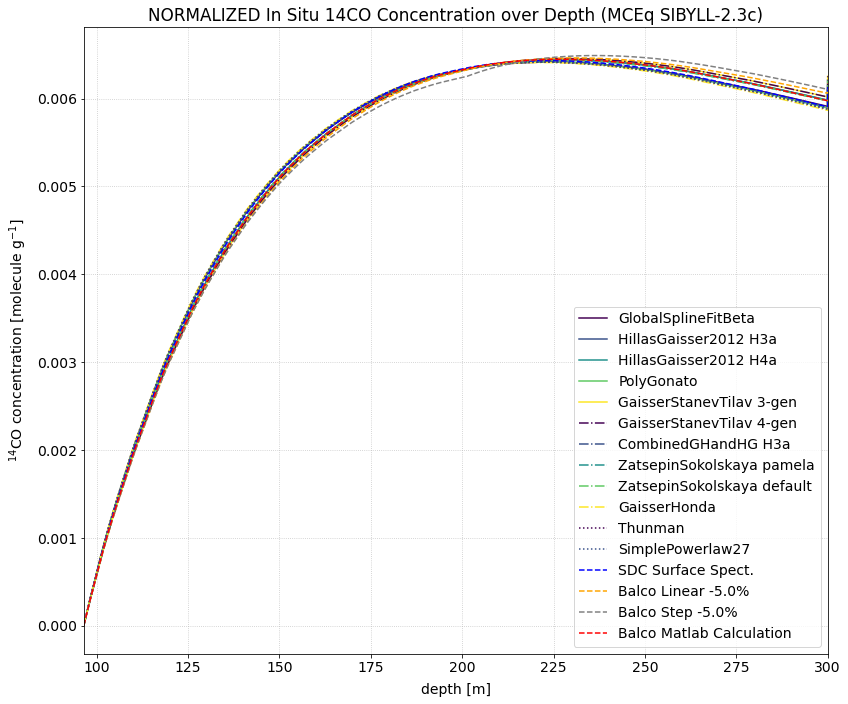

In [136]:
fig, ax = plt.subplots(1,1, figsize=(12,10), tight_layout=True)
#ax.fill_between(z, COH[0]*(1+df_star/f_star), COH[0]*(1-df_star/f_star), alpha=0.3)
#ax.fill_between(z, COH[1]*(1+dsigma_190/sigma_190), COH[1]*(1-dsigma_190/sigma_190), alpha=0.3)

#COH_err = np.sqrt((COH[1]*(dsigma_190/sigma_190))**2 + (COH[0]*(df_star/f_star))**2)
#ax.fill_between(z, np.sum(COH, axis=0)+COH_err, np.sum(COH, axis=0)-COH_err, alpha=0.3)

for i,CO in enumerate(CO_ALL):
    if i//5 == 0:
        ls = '-'
    elif i//5 == 1:
        ls = '-.'
    else:
        ls = ':'
    ax.plot(z[i_int], np.sum(CO, axis=0)/np.sum(CO*dh[i_int]), ls=ls, label=model_names[i])

ax.plot(z[i_int], np.sum(CO_SDC, axis=0)/np.sum(CO_SDC*dh[i_int]), c='b', ls='--', label='SDC Surface Spect.')
ax.plot(z[i_int], np.sum(CO_lin, axis=0)/np.sum(CO_lin*dh[i_int]), c='orange', ls='--', label='Balco Linear {:.1f}%'.format(slope*100))
ax.plot(z[i_int], np.sum(CO_step, axis=0)/np.sum(CO_step*dh[i_int]), c='grey', ls='--', label='Balco Step {:.1f}%'.format(step_amp*100))
ax.plot(z[i_int], np.sum(CO_pred, axis=0)/np.sum(CO_pred*dh[i_int]), c='r', ls='--', label='Balco Matlab Calculation')

ax.set(xlim=(z[i_int][0],z[i_int][-1]),
       xlabel='depth [m]',
       #ylim=(0,40),
       ylabel=r'$^{14}$CO concentration [molecule g$^{-1}$]')
ax.legend(loc='best', fontsize=14)
plt.title('NORMALIZED In Situ 14CO Concentration over Depth (MCEq {})'.format(interaction_model))

Text(0.5, 1.0, 'NORMALIZED In Situ 14CO Concentration over Depth (MCEq SIBYLL-2.3c)')

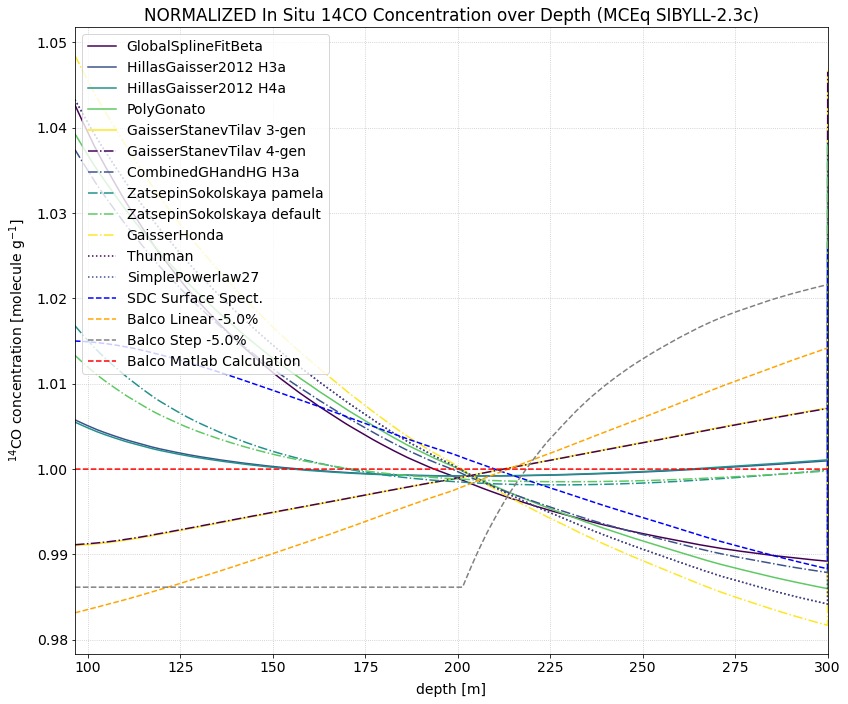

In [137]:
fig, ax = plt.subplots(1,1, figsize=(12,10), tight_layout=True)
#ax.fill_between(z, COH[0]*(1+df_star/f_star), COH[0]*(1-df_star/f_star), alpha=0.3)
#ax.fill_between(z, COH[1]*(1+dsigma_190/sigma_190), COH[1]*(1-dsigma_190/sigma_190), alpha=0.3)

#COH_err = np.sqrt((COH[1]*(dsigma_190/sigma_190))**2 + (COH[0]*(df_star/f_star))**2)
#ax.fill_between(z, np.sum(COH, axis=0)+COH_err, np.sum(COH, axis=0)-COH_err, alpha=0.3)

for i,CO in enumerate(CO_ALL):
    if i//5 == 0:
        ls = '-'
    elif i//5 == 1:
        ls = '-.'
    else:
        ls = ':'
    ax.plot(z[i_int], np.sum(CO, axis=0)/np.sum(CO*dh[i_int])*np.sum(CO_pred*dh[i_int])/np.sum(CO_pred, axis=0), ls=ls, label=model_names[i])

ax.plot(z[i_int], np.sum(CO_SDC, axis=0)/np.sum(CO_SDC*dh[i_int])*np.sum(CO_pred*dh[i_int])/np.sum(CO_pred, axis=0), c='b', ls='--', label='SDC Surface Spect.')
ax.plot(z[i_int], np.sum(CO_lin, axis=0)/np.sum(CO_lin*dh[i_int])*np.sum(CO_pred*dh[i_int])/np.sum(CO_pred, axis=0), c='orange', ls='--', label='Balco Linear {:.1f}%'.format(slope*100))
ax.plot(z[i_int], np.sum(CO_step, axis=0)/np.sum(CO_step*dh[i_int])*np.sum(CO_pred*dh[i_int])/np.sum(CO_pred, axis=0), c='grey', ls='--', label='Balco Step {:.1f}%'.format(step_amp*100))
ax.plot(z[i_int], np.sum(CO_pred, axis=0)/np.sum(CO_pred, axis=0), c='r', ls='--', label='Balco Matlab Calculation')

ax.set(xlim=(z[i_int][0],z[i_int][-1]),
       xlabel='depth [m]',
       #ylim=(0,40),
       ylabel=r'$^{14}$CO concentration [molecule g$^{-1}$]')
ax.legend(loc='upper left', fontsize=14)
plt.title('NORMALIZED In Situ 14CO Concentration over Depth (MCEq {})'.format(interaction_model))

In [125]:
# phi0 (Intensity)
# axis0 : Particle Energy
# axis1 : time (past -> present)

# Interaction Matrix (Muon Intensity / Primary Intensity)
# axis0 : depth
# axis1 : Muon Energy
# axis2 : Particle Energy

# phi_mu = Interaction Matrix @ phi0 (Muon Intensity)
# axis0 : depth
# axis1 : Muon Energy
# axis2 : time (past -> present)

# P_neg = d/dh sum_E(phi_mu- * dE) * f_all (14C Production Rate)
# axis0 : depth
# axis1 : time (past -> present)

# P_fast = sum_E(phi_mu * E^alpha * dE) * sigma_0 * N (14C Production Rate)
# axis0 : depth
# axis1 : time (past -> present)

# Lambda_dt = (1-lambda)^(delta_age) * dt
# axis0 : time (past -> present)

# C_neg = Convolve(P_neg, Lambda_dt) = Roll(P_neg) @ Lambda_dt
#       = f_all * Roll( d/dh @ (Interaction Matrix_neg @ dE) @ phi0) @ Lambda_dt
#       = f_all * Diag_sum( d/dh @ (Interaction Matrix_neg @ dE) @ (phi0 * lambda_dt) )
# axis0 : depth

# C_fast = Convolve(P_fast, Lambda_dt) = Roll(P_fast) @ Lambda_dt
#        = sigma_0 * N * Roll( (Interaction Matrix @ (E^alpha*dE)) @ phi0) @ Lambda_dt
#        = sigma_0 * N * Diag_sum( (Interaction Matrix @ (E^alpha*dE)) @ (phi0 * lambda_dt) )
# axis0 : depth

# CO = C_neg * f_neg + C_fast * f_fast
# axis0 : depth

# CO_comp = Compress @ CO
# axis0 : sample depth

In [303]:
# Roll for Convolve
#
# A B C
# D E F
# G H I
#
# A 0 0
# D B 0
# G E C
#
# Is this a linear transformation?
# No
#
# Convolve(A)
# A
# D+B
# G+E+C
#
# This is similar to the trace.  We're summing along the diagonals...

In [ ]:
# depth - t_production = final depth

In [223]:
def diag_sum(A, off=None, axis1=-2, axis2=-1):
    # sums along the upper diagonals of two axes in an array
    # the new axis replaces axis1; axis2 is eliminated.
    if off==None:
        off = np.flip(range(np.shape(A)[axis2]))
    return np.moveaxis(np.array([np.trace(A, offset=i, axis1=axis1, axis2=axis2) for i in off]), 0, axis1 if axis1>=0 else axis1+1)

In [112]:
np.shape(INT_fast)

(7284, 242)

In [163]:
INT_neg = -np.diff(np.sum(phi_mu_tot[i_int], axis=1), axis=0, append=0)/np.reshape(dh[i_int], (-1,1)) * f_C * f_D * f_star * f_mu_neg() /100 * 60 * 60 * 24 * 365.25

In [162]:
INT_fast = np.sum(phi_mu_tot[i_int] * np.reshape(E_grid, (1,-1,1))**alpha, axis=1) * sigma_190 / 190**alpha * N /100 * 60 * 60 * 24 * 365.25

In [234]:
INT = np.expand_dims(np.array([INT_neg, INT_fast]),axis=1)

In [164]:
lambda_dt = np.reshape((1-lambd)**(t[i_int][-1]-t[i_int]) * dt, (1, 1, -1))

In [165]:
Phi0 = np.expand_dims(np.array(Primaries), axis=2)

In [200]:
CO_neg = diag_sum(INT_neg @ (Phi0 * lambda_dt))

In [190]:
CO_fast = diag_sum(INT_fast @ (Phi0 * lambda_dt))

In [232]:
CO_all = diag_sum(INT @ (Phi0 * lambda_dt)).swapaxes(0,1)

In [228]:
np.shape(CO_all)

(12, 2, 7284)

In [239]:
F = np.array([[f_neg, f_fast]])

In [240]:
np.shape(F @ CO_all)

(12, 1, 7284)

In [213]:
np.shape(Phi0 * lambda_dt)

(12, 242, 7284)

In [140]:
# Phi0 : Primary CR Intensity models over time
# axis0 : Primary Model
# axis1 : Primary Energy
# axis2 : time (past -> present)

# lambda_dt : Fraction of 14C which survives to present * Time bin width
# axis0 : N/A
# axis1 : N/A
# axis2 : time (past -> present)

# INT_neg : Negative Capture production matrix
# axis0 : depth
# axis1 : Primary Energy

# INT_fast : Fast Interaction production matrix
# axis0 : depth
# axis1 : Primary Energy

# INT = [INT_neg, INT_fast] + axis1
# axis0 : production mode
# axis1 : N/A
# axis2 : depth
# axis3 : Primary Energy

# P_Rates = INT @ Phi0
# axis0 : production mode
# axis1 : Primary Model
# axis2 : depth
# axis3 : N/A

# C_modes = diag_sum(INT @ (Phi0 * lambda_dt)).swapaxes(0,1) = diag_sum(P_Rates * lambda_dt).swapaxes(0,1)
# axis0 : Primary Model
# axis1 : production mode
# axis2 : depth

# F : 14CO production factors
# axis0 : f_factor model
# axis1 : production mode

# CO = F @ C_modes
# axis0 : Primary Model
# axis1 : f_factor model
# axis2 : depth